In [1]:
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
import scipy.sparse as sp
import pickle

In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# folder_path = '/content/drive/MyDrive/hacaton_1/SERGEY/'
# df_path = folder_path + 'data_for_clasterisation.csv'

In [3]:
folder_path = './data'
df_path = folder_path + '/data_for_clasterisation.csv'

In [4]:
# Инициализация tqdm_pandas
tqdm.pandas()

# Вариант 1 . Рекомендательная система с категориями дат

# Вариант 2. Рекомендательная система с категориями дат

## 1. Загрузка данных

In [21]:
df = pd.read_csv(df_path, sep=';', encoding='utf-8')
df

,title,items,description,typology,author,date_category,key_words
0,Декоративный мотив.,"бумага, тушь",В вертикальной прямоугольной рамке декоративны...,графика,Малевич,1-я пол.20,"мотив,декоративный,нанизанными,стержень,диск,ц..."
1,Женский портрет в шляпе с пером. На обороте: Н...,"бумага, графитный карандаш, растушевка","Портрет женщины в шляпе с пером (фронтально, о...",графика,Малевич,2-я пол.20,"младенец,оборот,шляпа,на,женщина,портрет,пером..."
2,Декоративные мотивы. Три виньетки,"бумага верже, тушь, перо",Три виньетки. Слева: овальная виньетка с цвето...,графика,Малевич,1-я пол.20,"виньетка,прямоугольный,три,стеблями,рамка,симм..."
3,Два женских портрета.,"бумага, черные чернила","Один под другим, в рамках: два женских портрет...",графика,Малевич,1-я пол.20,"изображенной,недлинный,распущенные,платье,женс..."
4,Женский портрет (погрудный).,"бумага, бумага цветная, тушь, гуашь, наклейка",В круге: на фоне с цветочными узорами - поясн...,графика,Малевич,2-я пол.20,"круг,крапинка,вставка,цветочный,картон,портрет..."
...,...,...,...,...,...,...,...
35702,Портрет Анны Андреевны Ахматовой.,"холст, масло","Ахматова изображена по плечи, с поворотом слег...",живопись,Петров-Водкин,1-я пол.20,"ахматов,синий,подстричь,горбинка,андреевич,отл..."
35703,Зима.,"холст, масло",Городской пейзаж. На первом плане: справа руин...,живопись,Павлов,1-я пол.20,"дом,серый,полуразрушенные,разбитый,кирпичный,в..."
35704,Лестница. Ленинский проспект,"холст, масло",Абстрактная композиция состоящая из прямоуголь...,живопись,Волков,2-я пол.20,"ленинский,овала,проспект,напоминать,цветной,со..."
35705,Без названия,"холст на фанере, масло",В верхней части картины - летящий влево желты...,живопись,Добротворский,2-я пол.20,"расклешенной,планета,картина,парить,воздух,кра..."


In [22]:
df['key_words'] = df['key_words'].fillna('')
df['key_words'] = df['key_words'] + ',' + df['author']

In [23]:
df

,title,items,description,typology,author,date_category,key_words
0,Декоративный мотив.,"бумага, тушь",В вертикальной прямоугольной рамке декоративны...,графика,Малевич,1-я пол.20,"мотив,декоративный,нанизанными,стержень,диск,ц..."
1,Женский портрет в шляпе с пером. На обороте: Н...,"бумага, графитный карандаш, растушевка","Портрет женщины в шляпе с пером (фронтально, о...",графика,Малевич,2-я пол.20,"младенец,оборот,шляпа,на,женщина,портрет,пером..."
2,Декоративные мотивы. Три виньетки,"бумага верже, тушь, перо",Три виньетки. Слева: овальная виньетка с цвето...,графика,Малевич,1-я пол.20,"виньетка,прямоугольный,три,стеблями,рамка,симм..."
3,Два женских портрета.,"бумага, черные чернила","Один под другим, в рамках: два женских портрет...",графика,Малевич,1-я пол.20,"изображенной,недлинный,распущенные,платье,женс..."
4,Женский портрет (погрудный).,"бумага, бумага цветная, тушь, гуашь, наклейка",В круге: на фоне с цветочными узорами - поясн...,графика,Малевич,2-я пол.20,"круг,крапинка,вставка,цветочный,картон,портрет..."
...,...,...,...,...,...,...,...
35702,Портрет Анны Андреевны Ахматовой.,"холст, масло","Ахматова изображена по плечи, с поворотом слег...",живопись,Петров-Водкин,1-я пол.20,"ахматов,синий,подстричь,горбинка,андреевич,отл..."
35703,Зима.,"холст, масло",Городской пейзаж. На первом плане: справа руин...,живопись,Павлов,1-я пол.20,"дом,серый,полуразрушенные,разбитый,кирпичный,в..."
35704,Лестница. Ленинский проспект,"холст, масло",Абстрактная композиция состоящая из прямоуголь...,живопись,Волков,2-я пол.20,"ленинский,овала,проспект,напоминать,цветной,со..."
35705,Без названия,"холст на фанере, масло",В верхней части картины - летящий влево желты...,живопись,Добротворский,2-я пол.20,"расклешенной,планета,картина,парить,воздух,кра..."


## 2. Кодирование признаков

In [24]:
# Загрузка предобученной модели для русского языка
model_name = 'DeepPavlov/rubert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
# Функция для получения эмбеддингов с помощью RuBERT
def get_embeddings(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings

In [26]:
def get_item_embeddings(data):
    descriptions = data['key_words'].tolist()

    embeddings = []

    # Получаем эмбеддинги для каждого экспоната
    for desc in tqdm(descriptions, desc="Генерация эмбеддингов для описаний", unit="экспонат"):
        embedding = get_embeddings([desc])
        embeddings.append(embedding)

    # Преобразуем список эмбеддингов в numpy массив
    embeddings = torch.cat(embeddings, dim=0).numpy()

    # Сохраняем эмбеддинги в файл
    np.save('../data/key_words_embeddings.npy', embeddings)

    return embeddings

In [33]:
embeddings = get_item_embeddings(df)

Генерация эмбеддингов для описаний: 100%|██████████| 35707/35707 [52:32<00:00, 11.33экспонат/s]  


## Рекомендательная система на основе KMeans

In [34]:
# Количество кластеров
def create_kmeans_model(embeddings, n_clusters=20):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(embeddings)
    return kmeans

In [39]:
kmeans_model_kw = create_kmeans_model(embeddings, n_clusters=20)

In [40]:
# Сохранение модели
with open('../data/kmeans_model_kw.pkl', 'wb') as f:
    pickle.dump(kmeans_model_kw, f)

In [41]:
kmeans_model_kw = pickle.load(open('../data/kmeans_model_kw.pkl', 'rb'))

In [42]:
# Прогнозируем, к какому кластеру принадлежит каждый экспонат
cluster_labels = kmeans_model_kw.predict(embeddings)

# Добавляем информацию о кластере в данные
df['cluster'] = cluster_labels

In [43]:
df.to_csv(folder_path + 'data_with_clasters_kw.csv', encoding='utf-8', sep=';')

In [44]:
df = pd.read_csv(folder_path + 'data_with_clasters_kw.csv', encoding='utf-8', sep=';')

In [47]:
def visualize_clusters(features, data, method="PCA"):
    # Снижение размерности
    print(f"Снижение размерности с использованием {method}...")
    if method == "PCA":
        reducer = PCA(n_components=2)
    elif method == "TSNE":
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    else:
        raise ValueError("Метод должен быть 'PCA' или 'TSNE'")

    reduced_features = reducer.fit_transform(features)

    # Создание DataFrame для визуализации
    visualization_df = pd.DataFrame(reduced_features, columns=["Dim1", "Dim2"])
    visualization_df['cluster'] = data['cluster']

    # Визуализация
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x="Dim1", y="Dim2",
        hue="cluster",
        palette="tab10",
        data=visualization_df,
        legend="full"
    )
    plt.title(f"Визуализация кластеров ({method})", fontsize=16)
    plt.xlabel("Первая компонента", fontsize=12)
    plt.ylabel("Вторая компонента", fontsize=12)
    plt.legend(title="Кластеры")
    plt.show()

Снижение размерности с использованием PCA...


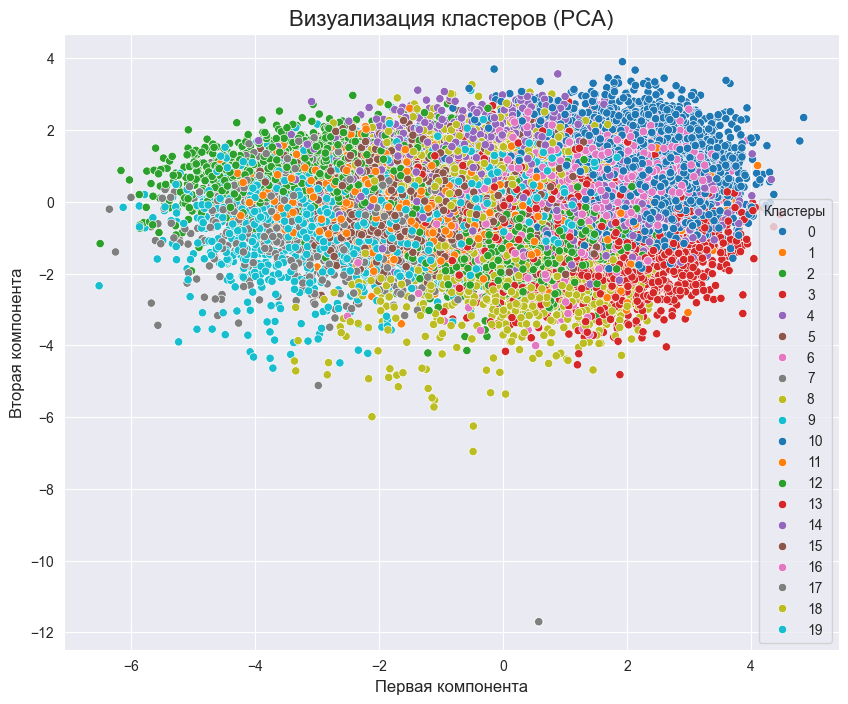

In [48]:
# Визуализация кластеров с использованием PCA
visualize_clusters(embeddings, df, method="PCA")

Снижение размерности с использованием TSNE...


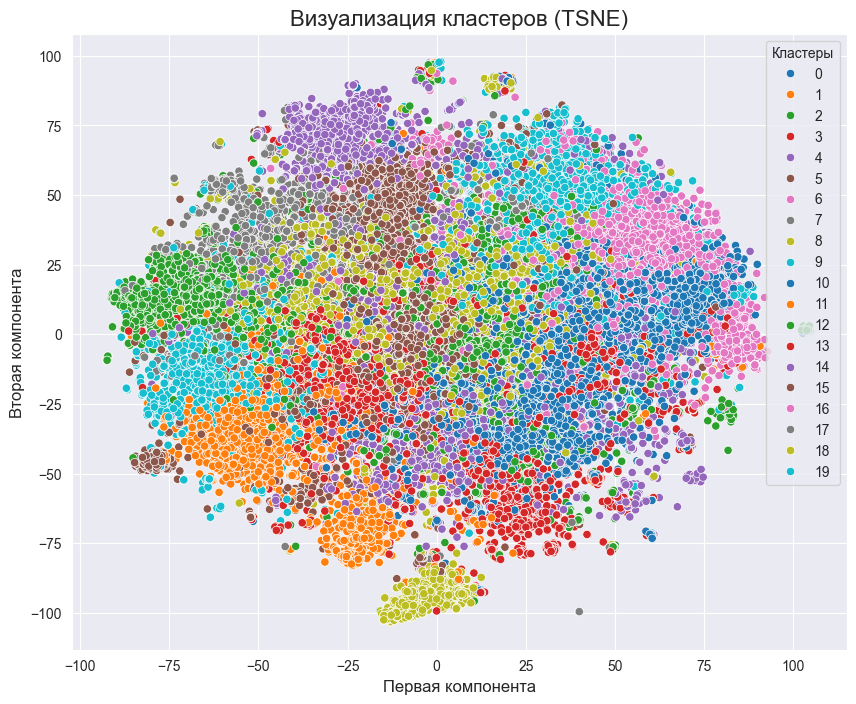

In [49]:
# Визуализация кластеров с использованием TSNE
visualize_clusters(embeddings, df, method="TSNE")

In [50]:
# Функция для дополнения эмбеддинга запроса до требуемой размерности
def resize_embedding(query_embedding, target_dim):
    current_dim = query_embedding.shape[1]
    if current_dim == target_dim:
        return query_embedding
    if current_dim < target_dim:
        padding = np.zeros((query_embedding.shape[0], target_dim - current_dim))
        return np.hstack([query_embedding, padding])
    return query_embedding[:, :target_dim]

In [51]:
# Рекомендация экспонатов по кластеру
def recommend_by_cluster(query, data, kmeans_model, n_recommendations=5):
    # Получаем целевую размерность из KMeans
    target_dim = kmeans_model.cluster_centers_.shape[1]

    # Получаем эмбеддинг запроса
    query_embedding = get_embeddings([query]).numpy()

    # Приводим эмбеддинг к нужной размерности
    query_embedding_resized = resize_embedding(query_embedding, target_dim)

    query_cluster = kmeans_model.predict(query_embedding_resized)
    recommended_items = data[data['cluster'] == query_cluster[0]].head(n_recommendations)
    return recommended_items

In [52]:
# Пример: Рекомендуем экспонаты для пользователя с запросом
user_query = "картина, изображающая пейзаж с озером"
recommended_items = recommend_by_cluster(user_query, df, kmeans_model_kw)
recommended_items[['title', 'author', 'date_category']]

,title,author,date_category
102,Наброски лошадей и козы.,Рождественский,1-я пол.20
105,Тополь пирамидальный. С набросками на полях.,Рождественский,1-я пол.20
109,Два дерева.,Рождественский,1-я пол.20
113,Пляж.,Рождественский,1-я пол.20
127,Автопортрет.,Рождественский,1-я пол.20


## Рекомендательная система на основе KMeans + косинусное сходство

In [53]:
def recommend_by_kmeans_cosine(query, data, embeddings, kmeans_model, n_recommendations=5):
    target_dim = kmeans_model.cluster_centers_.shape[1]

    # Получаем эмбеддинг запроса
    query_embedding = get_embeddings([query]).numpy()

    # Приводим эмбеддинг к нужной размерности
    query_embedding_resized = resize_embedding(query_embedding, target_dim)

    # Определяем кластер для запроса
    query_cluster = kmeans_model.predict(query_embedding_resized)

    # Получаем индексы объектов в этом кластере
    cluster_indices = np.where(kmeans_model.labels_ == query_cluster)[0]

    # Если embeddings - разреженная матрица, конвертируем в плотный массив
    if isinstance(embeddings, np.ndarray):
        cluster_embeddings = embeddings[cluster_indices]
    else:
        cluster_embeddings = np.asarray(embeddings.todense()[cluster_indices])

    # Вычисляем косинусное сходство между эмбеддингом запроса и всеми объектами в выбранном кластере
    similarities = cosine_similarity(query_embedding_resized, cluster_embeddings).flatten()

    # Получаем индексы наиболее похожих объектов в кластере
    most_similar_indices = similarities.argsort()[-n_recommendations:][::-1]

    # Возвращаем самые похожие объекты
    recommended_items = data.iloc[cluster_indices[most_similar_indices]]

    return recommended_items


In [54]:
# Пример: Рекомендуем экспонаты для пользователя с запросом
user_query = "картина, изображающая пейзаж с озером"
recommended_items = recommend_by_kmeans_cosine(user_query, df, embeddings, kmeans_model_kw)
recommended_items[['title', 'author', 'date_category']]

,title,author,date_category
24008,Роща,Куинджи,1-я пол.20
13850,Автопортрет,Врубель,2-я пол.19
127,Автопортрет.,Рождественский,1-я пол.20
11493,Семейный портрет,Боровиковский,2-я пол.18
1373,После дождя. Этюд.,Куинджи,2-я пол.19


In [ ]:
# Вычисляем косинусное сходство для всех объектов
cosine_sim = cosine_similarity(embeddings)

# Визуализируем косинусное сходство в виде тепловой карты
plt.figure(figsize=(12, 8))
sns.heatmap(cosine_sim, cmap='viridis', xticklabels=df['key_words'], yticklabels=df['key_words'])
plt.title('Cosine Similarity Heatmap')
plt.show()

## Рекомендательная система на основе KMeans + NearestNeighbours

In [55]:
def recommend_by_kmeans_knn(query, data, embeddings, kmeans_model, n_recommendations=5):
    target_dim = kmeans_model.cluster_centers_.shape[1]

    # Получаем эмбеддинг запроса
    query_embedding = get_embeddings([query]).numpy()

    # Приводим эмбеддинг к нужной размерности
    query_embedding_resized = resize_embedding(query_embedding, target_dim)

    # Определяем кластер для запроса
    query_cluster = kmeans_model.predict(query_embedding_resized)

    # Получаем индексы объектов в этом кластере
    cluster_indices = np.where(kmeans_model.labels_ == query_cluster)[0]

    # Если embeddings - разреженная матрица, конвертируем в плотный массив
    if isinstance(embeddings, np.ndarray):
        cluster_embeddings = embeddings[cluster_indices]
    else:
        cluster_embeddings = np.asarray(embeddings.todense()[cluster_indices])

    # Создаем модель NearestNeighbors
    nn_model = NearestNeighbors(n_neighbors=n_recommendations, metric='cosine')
    nn_model.fit(cluster_embeddings)

    # Находим ближайших соседей для запроса в этом кластере
    distances, indices = nn_model.kneighbors(query_embedding_resized)

    # Возвращаем рекомендованные объекты
    recommended_items = data.iloc[cluster_indices[indices.flatten()]]

    return recommended_items

In [56]:
# Пример: Рекомендуем экспонаты для пользователя с запросом
user_query = "картина, изображающая пейзаж с озером"
recommended_items = recommend_by_kmeans_knn(user_query, df, embeddings, kmeans_model_kw)
recommended_items[['title', 'author', 'date_category']]

,title,author,date_category
24008,Роща,Куинджи,1-я пол.20
13850,Автопортрет,Врубель,2-я пол.19
127,Автопортрет.,Рождественский,1-я пол.20
11493,Семейный портрет,Боровиковский,2-я пол.18
1373,После дождя. Этюд.,Куинджи,2-я пол.19


## Рекомендательная система на основе KNN

In [59]:
# Создание модели для поиска ближайших соседей
def create_knn_model(embeddings, n_neighbors=10):
    knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
    knn.fit(embeddings)
    return knn

In [60]:
# Создадим модель kNN
knn_model_kw = create_knn_model(embeddings, n_neighbors=20)

In [61]:
# Сохранение модели
with open('../data/knn_model_kw.pkl', 'wb') as f:
    pickle.dump(knn_model_kw, f)

In [62]:
# Пример функции для рекомендации на основе KNN
def recommend_by_knn(query, knn_model, data, n_recommendations=5):
    # Преобразуем запрос пользователя в эмбеддинг
    query_embedding = get_embeddings([query]).numpy()

    # Получаем целевую размерность из KMeans
    target_dim = knn_model._fit_X.shape[1]

    # Приводим эмбеддинг к нужной размерности
    query_embedding_resized = resize_embedding(query_embedding, target_dim)

    # Находим ближайших соседей
    distances, indices = knn_model.kneighbors(query_embedding_resized, n_neighbors=n_recommendations)

    # Возвращаем рекомендованные экспонаты
    recommended_items = data.iloc[indices[0]]

    return recommended_items

In [63]:
# Пример: Рекомендуем экспонаты для пользователя с запросом
user_query = "картина, изображающая пейзаж с озером"
recommended_items = recommend_by_knn(user_query, knn_model_kw, df)
print(recommended_items[['title', 'author', 'date_category']])

                    title          author date_category
24008                Роща         Куинджи    1-я пол.20
13850         Автопортрет         Врубель    2-я пол.19
127          Автопортрет.  Рождественский    1-я пол.20
11493    Семейный портрет   Боровиковский    2-я пол.18
1373   После дождя. Этюд.         Куинджи    2-я пол.19


In [64]:
def visualize_knn_neighbors(query, knn_model, data, n_neighbors=20):
    # Получаем эмбеддинг запроса
    query_embedding = get_embeddings([query]).numpy()
    # Получаем целевую размерность из KMeans
    target_dim = knn_model._fit_X.shape[1]

    # Приводим эмбеддинг к нужной размерности
    query_embedding_resized = resize_embedding(query_embedding, target_dim)

    # Находим ближайших соседей
    distances, indices = knn_model.kneighbors(query_embedding_resized, n_neighbors=n_neighbors)

    # Извлекаем ближайшие экспонаты
    neighbors = data.iloc[indices[0]]

    # Применяем PCA для сокращения размерности
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)

    # Визуализируем запрос и ближайших соседей
    plt.figure(figsize=(10, 8))

    # Визуализируем все точки
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, label='Экспонаты')

    # Визуализируем ближайших соседей
    plt.scatter(embeddings_2d[indices[0], 0], embeddings_2d[indices[0], 1], color='red', label='Ближайшие соседи')

    # Визуализируем запрос
    query_2d = pca.transform(query_embedding_resized)
    plt.scatter(query_2d[0, 0], query_2d[0, 1], color='green', marker='x', label='Запрос')

    plt.legend()
    plt.title(f'Визуализация ближайших соседей для запроса: "{query}"')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

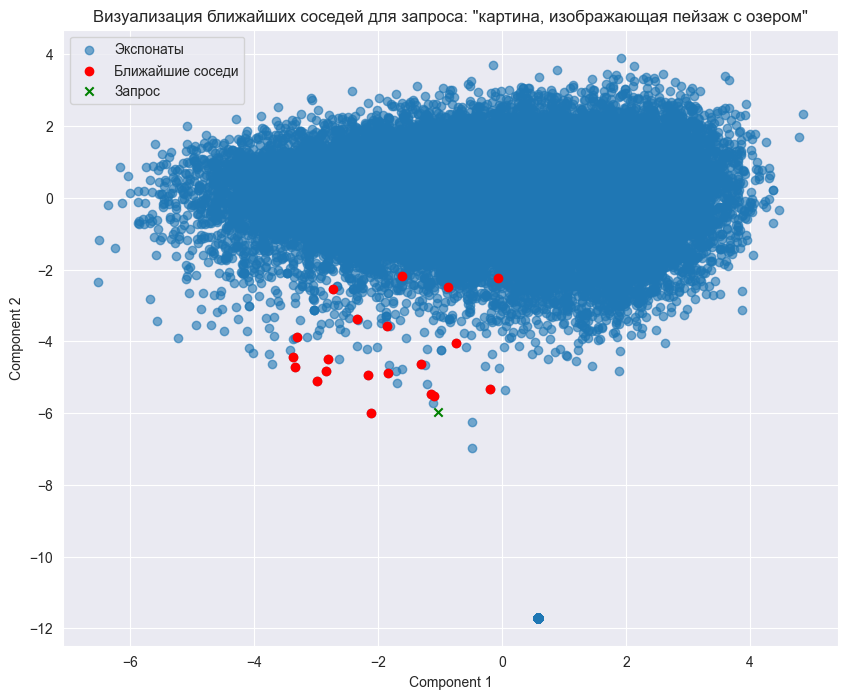

In [65]:
visualize_knn_neighbors(user_query, knn_model_kw, df)